# Men are worse drivers, but only slightly

This is a Jupyter Notebook for analyzing the traffic collision data available for Los Angeles County through <a href="http://tims.berkeley.edu">TIMS</a>. The analysis uses the Pandas package in Python:


In [3]:
import pandas

The data can be downloaded from TIMS with a user account. Only ~5000 collisions may be downloaded at a time. This allows for about one month worth of data for Los Angeles County. 

Here, the data for the parties involved in traffic collisions fron January 2012 in Los Angeles County is used.

In [4]:
#Load the data, show data size

data = pandas.read_csv('Jan12Parties.csv')
data.shape

(8893, 34)

There were 8893 parties in recorded accidents in Los Angeles County in Jan 2012. This database records all parties involved in a collision: perpetrator, victim, affected bystanders etc.

In [5]:
# What does the data look like? limit to first five rows

data.iloc[:5,:]

,CASEID,PARNUM,PTYPE,ATFAULT,PSEX,PAGE,PSOBER,PDRUG,PDIRECT,PSAFETY1,...,VEHYEAR,VEHMAKE,VEHTYPE,CHPTYPE1,CHPTYPE2,PRACE,INATTN,TRUCKCMB,TRAILRCMB,YEAR_
0,5980867,1,1,Y,M,57,A,-,S,L,...,1997,HONDA,A,01,00,B,NaN,-,-,2012
1,5980827,2,1,Y,M,18,A,-,S,L,...,1996,FORD,A,01,00,W,NaN,-,-,2012
2,5980827,1,1,N,F,56,A,-,S,M,...,2001,KIA,A,07,00,B,NaN,-,-,2012
3,5980823,2,1,N,F,31,A,-,N,M,...,2005,NISSAN,A,01,00,O,NaN,-,-,2012
4,5980823,1,2,Y,M,50,G,G,W,-,...,0,-,N,60,00,B,NaN,-,-,2012


# Querying a Pandas DataFrame

Pandas DataFrames can be queried in a way which is conceptually (though not syntactically) similar to SQL databases.

First, let's count up the total number of incidents (unique CASEID), and compare that to the number of parties.

In [5]:
cases = data.CASEID.nunique()
cases

4146

So there were 4146 cases (collisions) and 8893 parties. That means an average of 8893/4146 = 2.14 parties per case.

Next, we will group by sex and fault, then count the entries with each unique combination of levels on these columns.

In [8]:
#Count parties by sex & fault

faultgender = data.groupby(['ATFAULT','PSEX']).count().iloc[:,[0]].rename(columns = {'CASEID':'counts'})
faultgender

counts
ATFAULT PSEX        
N       -        481
        F       1938
        M       2577
Y       -        297
        F       1369
        M       2231

In [9]:
fg = faultgender.reset_index()
fg = fg[fg.PSEX != '-']
fg

,ATFAULT,PSEX,counts
1,N,F,1938
2,N,M,2577
4,Y,F,1369
5,Y,M,2231


In [10]:
#relative probabilites?

float(2231)/(1369+2231)/0.5

1.2394444444444443

# Correcting for confounders

This would seem to indicate that men are ~24% more likely to cause accidents, based on the assumption that men and women are equal portions of the population. However, due to the confounder of men being more likely to drive (due to driving/delivery occupations etc.) this is probably not quite true.

Luckily, the data contains enough information to correct for this, at least partly. The database includes information about both the perpetrators and victims of crashes, which should correct for the hypothesis that there are more men driving. For each gender, we can calculate the probability of being at fault. Then we can calculate the relative risk of being at fault, conditioning on being male.

$\large RR = \frac{P(Fault | Male)}{P(Fault | Female)}$

In [11]:
# Get values from dataframes
NF = float(fg.counts[(fg.PSEX == 'F')&(fg.ATFAULT == 'N')].values[0])
NM = float(fg.counts[(fg.PSEX == 'M')&(fg.ATFAULT == 'N')].values[0])
YF = float(fg.counts[(fg.PSEX == 'F')&(fg.ATFAULT == 'Y')].values[0])
YM = float(fg.counts[(fg.PSEX == 'M')&(fg.ATFAULT == 'Y')].values[0])

#probability of being at fault for male parties
PM = YM/(YM+NM)
#probability of being at fault for female parties
PF = YF/(YF+NF)
#Relative risk of being at fault, given being a party in a traffic accident and being male
RR = PM/PF
[PM,PF,RR]

[0.46401830282861894, 0.4139703658905352, 1.1208973903975479]

# Conclusion...

So men are ~12% more likely to be at fault in a collision, at least during January 2012 in Los Angeles County. We can also plot data in this notebook as follows.

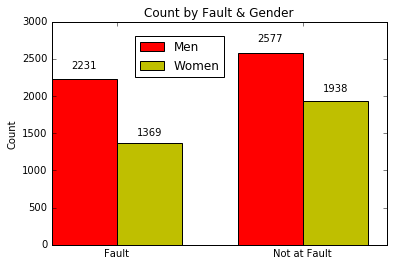

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

N = 2
Men = (YM, NM)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, Men, width, color='r')

Women = (YF, NF)
rects2 = ax.bar(ind + width, Women, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Count by Fault & Gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Fault','Not at Fault'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'),loc=(0.25,0.75))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()